# Conditional VAEs, GANs and Conditional GANs

```{admonition} Run this webpage in Google Colab using the <i class="fas fa-rocket"></i> icon.
:class: warning
This lecture notes uses packages including pytorch, torchvision. Use Google Colab icon to run the code. Pytorch does not work with live code yet.
```

<div>
<iframe src="https://slides.com/naresh-ub/cvip-lec-13-14/embed" width="100%" height="500" title="Intro to GenAI" scrolling="no" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe>
</div>

## 1. Conditional Variational Autoencoders (CVAEs)

### 1.1 Motivation

The standard VAE generates data from an unstructured latent space. But often we want **controlled generation** based on side information (e.g., labels, class, attributes).  

This leads to **Conditional VAEs**, where generation is conditioned on $ \mathbf{y} $ (a label or auxiliary variable).  

---

### 1.2 Formulation

The generative model becomes:

$$
p_{\theta}(\mathbf{x}, \mathbf{z} \mid \mathbf{y}) = p_{\theta}(\mathbf{x} \mid \mathbf{z}, \mathbf{y}) \, p(\mathbf{z} \mid \mathbf{y})
$$

- $ \mathbf{y} $: conditioning variable (e.g., digit label in MNIST).  
- $ p(\mathbf{z} \mid \mathbf{y}) $: prior over latent code given condition.  
- $ p_{\theta}(\mathbf{x} \mid \mathbf{z}, \mathbf{y}) $: decoder likelihood.

The posterior is:

$$
p_{\theta}(\mathbf{z} \mid \mathbf{x}, \mathbf{y}) = \frac{p_{\theta}(\mathbf{x} \mid \mathbf{z}, \mathbf{y}) \, p(\mathbf{z} \mid \mathbf{y})}{p_{\theta}(\mathbf{x} \mid \mathbf{y})}
$$

As in VAEs, this posterior is intractable. We introduce an **encoder network**:

$$
q_{\phi}(\mathbf{z} \mid \mathbf{x}, \mathbf{y})
$$

---

### 1.3 Conditional ELBO

The conditional Evidence Lower Bound is:

$$
\log p_{\theta}(\mathbf{x} \mid \mathbf{y}) \geq \mathbb{E}_{q_{\phi}(\mathbf{z} \mid \mathbf{x}, \mathbf{y})} \Big[ \log p_{\theta}(\mathbf{x} \mid \mathbf{z}, \mathbf{y}) \Big] - \text{KL}\!\left( q_{\phi}(\mathbf{z} \mid \mathbf{x}, \mathbf{y}) \;\| \; p(\mathbf{z} \mid \mathbf{y}) \right)
$$

This loss ensures:
- Reconstruction quality given condition $ \mathbf{y} $.  
- Latent space regularization conditioned on $ \mathbf{y} $.  

---

### 1.4 Reparameterization Trick in CVAEs
Same as VAE, but conditioning variable $ \mathbf{y} $ is concatenated (or embedded) into both encoder and decoder:

$$
\mathbf{z} = \mu_{\phi}(\mathbf{x}, \mathbf{y}) + \sigma_{\phi}(\mathbf{x}, \mathbf{y}) \odot \boldsymbol{\epsilon}, \quad \boldsymbol{\epsilon} \sim \mathcal{N}(0, I)
$$


Using device: cuda
Epoch [1/20] Total Loss: 163.5236 BCE: 149.4420 KLD: 14.0816
Epoch [2/20] Total Loss: 119.6404 BCE: 99.2626 KLD: 20.3778
Epoch [3/20] Total Loss: 112.7282 BCE: 91.0664 KLD: 21.6619
Epoch [4/20] Total Loss: 109.5130 BCE: 87.5362 KLD: 21.9768
Epoch [5/20] Total Loss: 107.4801 BCE: 85.4363 KLD: 22.0438


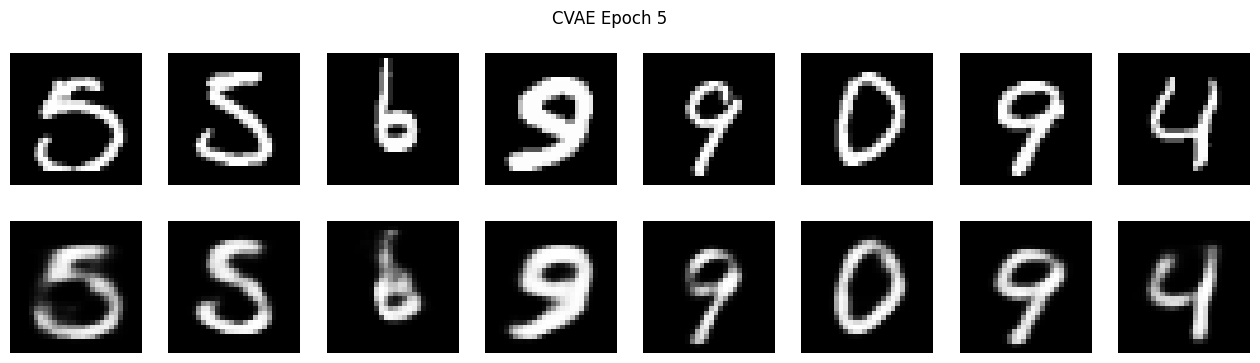

Epoch [6/20] Total Loss: 106.0014 BCE: 83.9689 KLD: 22.0325
Epoch [7/20] Total Loss: 104.9409 BCE: 82.8892 KLD: 22.0517
Epoch [8/20] Total Loss: 103.9812 BCE: 82.0079 KLD: 21.9733
Epoch [9/20] Total Loss: 103.2834 BCE: 81.3241 KLD: 21.9593
Epoch [10/20] Total Loss: 102.6958 BCE: 80.8061 KLD: 21.8897


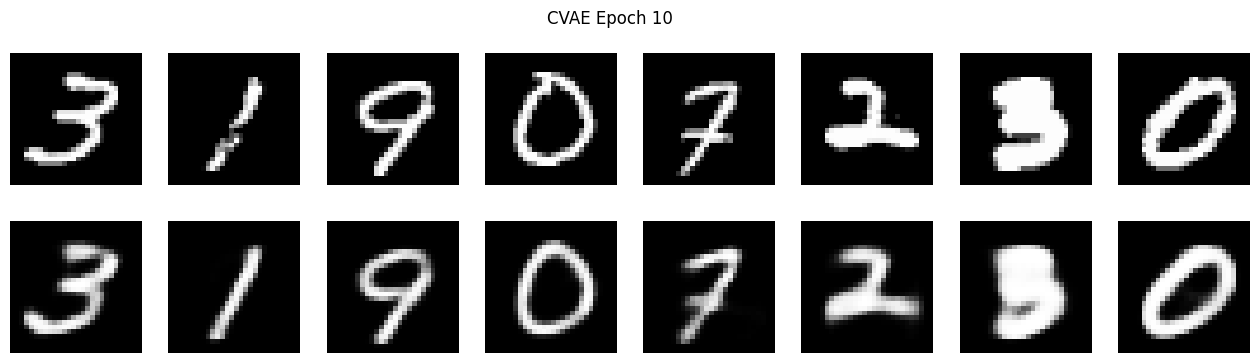

Epoch [11/20] Total Loss: 102.2583 BCE: 80.3674 KLD: 21.8909
Epoch [12/20] Total Loss: 101.8285 BCE: 79.9733 KLD: 21.8551
Epoch [13/20] Total Loss: 101.4563 BCE: 79.5976 KLD: 21.8587
Epoch [14/20] Total Loss: 101.1424 BCE: 79.3162 KLD: 21.8262
Epoch [15/20] Total Loss: 100.8655 BCE: 79.0628 KLD: 21.8027


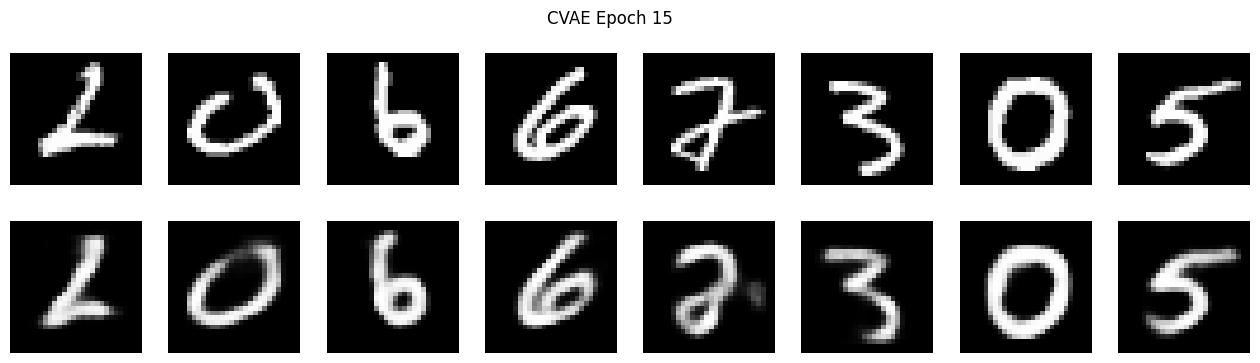

Epoch [16/20] Total Loss: 100.5906 BCE: 78.8095 KLD: 21.7811
Epoch [17/20] Total Loss: 100.3771 BCE: 78.6241 KLD: 21.7530
Epoch [18/20] Total Loss: 100.1733 BCE: 78.4385 KLD: 21.7347
Epoch [19/20] Total Loss: 99.9725 BCE: 78.2428 KLD: 21.7297
Epoch [20/20] Total Loss: 99.7892 BCE: 78.0683 KLD: 21.7209


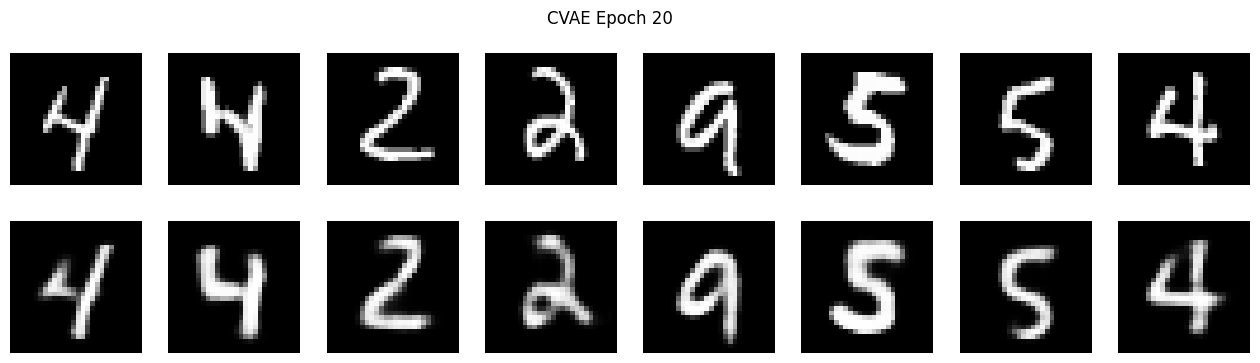

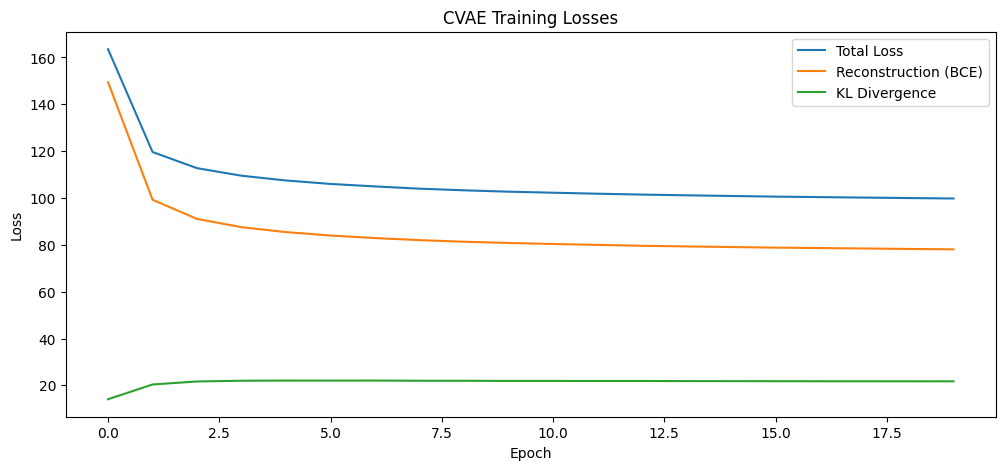

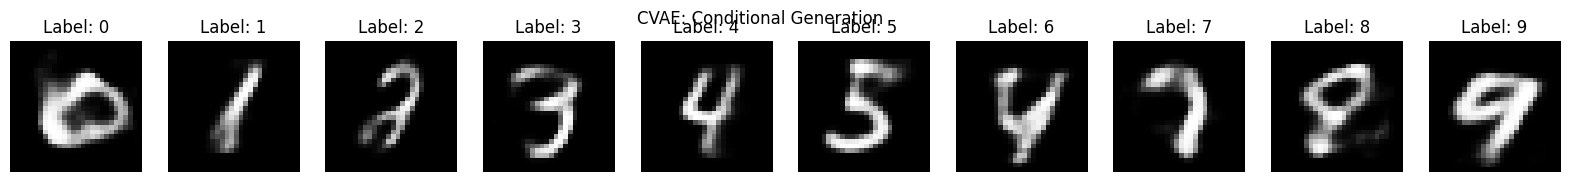

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# -----------------------------
# Config
# -----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

batch_size = 128
learning_rate = 1e-3
num_epochs = 20
latent_dim = 20
label_dim = 10
img_size = 28 * 28

# -----------------------------
# Data
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# -----------------------------
# Conditional VAE
# -----------------------------
class CVAE(nn.Module):
    def __init__(self, img_size, label_dim, latent_dim):
        super(CVAE, self).__init__()
        self.img_size = img_size
        self.label_dim = label_dim
        self.latent_dim = latent_dim

        # Encoder: x + label -> mu, logvar
        self.fc1 = nn.Linear(img_size + label_dim, 400)
        self.fc21 = nn.Linear(400, latent_dim)
        self.fc22 = nn.Linear(400, latent_dim)

        # Decoder: z + label -> x
        self.fc3 = nn.Linear(latent_dim + label_dim, 400)
        self.fc4 = nn.Linear(400, img_size)

    def encode(self, x, y):
        h1 = F.relu(self.fc1(torch.cat([x, y], dim=1)))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        h3 = F.relu(self.fc3(torch.cat([z, y], dim=1)))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, y), mu, logvar

model = CVAE(img_size, label_dim, latent_dim).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -----------------------------
# Helper: one-hot encoding
# -----------------------------
def one_hot(labels, num_classes):
    return torch.eye(num_classes)[labels].to(DEVICE)

# -----------------------------
# Loss
# -----------------------------
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD

# -----------------------------
# Train loop
# -----------------------------
train_total_losses = []
train_bces = []
train_klds = []

for epoch in range(num_epochs):
    model.train()
    total_loss, total_bce, total_kld = 0, 0, 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.view(-1, img_size).to(DEVICE)
        labels_onehot = one_hot(labels, label_dim)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, labels_onehot)
        loss, bce, kld = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_bce += bce.item()
        total_kld += kld.item()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_bce = total_bce / len(train_loader.dataset)
    avg_kld = total_kld / len(train_loader.dataset)

    train_total_losses.append(avg_loss)
    train_bces.append(avg_bce)
    train_klds.append(avg_kld)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Total Loss: {avg_loss:.4f} "
          f"BCE: {avg_bce:.4f} "
          f"KLD: {avg_kld:.4f}")

    # Reconstructions
    if (epoch + 1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            test_batch, test_labels = next(iter(test_loader))
            test_batch = test_batch.view(-1, img_size).to(DEVICE)
            test_labels_onehot = one_hot(test_labels, label_dim)
            recon_batch, _, _ = model(test_batch, test_labels_onehot)

            fig, axs = plt.subplots(2, 8, figsize=(16, 4))
            for i in range(8):
                axs[0, i].imshow(test_batch[i].cpu().view(28, 28).numpy(), cmap='gray')
                axs[0, i].axis('off')
                axs[1, i].imshow(recon_batch[i].cpu().view(28, 28).numpy(), cmap='gray')
                axs[1, i].axis('off')
            axs[0, 0].set_ylabel('Original')
            axs[1, 0].set_ylabel('Reconstructed')
            plt.suptitle(f"CVAE Epoch {epoch+1}")
            plt.show()

# -----------------------------
# Plot Losses
# -----------------------------
plt.figure(figsize=(12, 5))
plt.plot(train_total_losses, label='Total Loss')
plt.plot(train_bces, label='Reconstruction (BCE)')
plt.plot(train_klds, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CVAE Training Losses')
plt.legend()
plt.show()

# -----------------------------
# Conditional Sampling
# -----------------------------
model.eval()
with torch.no_grad():
    sample_labels = torch.arange(0, 10).long() # [0, 1, ..., 9]
    sample_labels_onehot = one_hot(sample_labels, label_dim) # [10, 10] one-hot encoded labels
    z = torch.randn(10, latent_dim).to(DEVICE)
    samples = model.decode(z, sample_labels_onehot)

    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    for i in range(10):
        axs[i].imshow(samples[i].cpu().view(28, 28).numpy(), cmap='gray')
        axs[i].set_title(f"Label: {i}")
        axs[i].axis('off')
    plt.suptitle("CVAE: Conditional Generation")
    plt.show()

## 2. Generative Adversarial Networks (GANs)

### 2.1 Motivation
Unlike VAEs, GANs directly learn to generate samples by framing the task as a **two-player minimax game** between:

- **Generator $ G $**: maps random noise $ \mathbf{z} \sim p(\mathbf{z}) $ to synthetic data $ G(\mathbf{z}) $.  
- **Discriminator $ D $**: distinguishes between real data $ \mathbf{x} \sim p_{\text{data}} $ and generated samples $ G(\mathbf{z}) $.

---

### 2.2 GAN Objective

The GAN loss function is:

$$
\min_{G} \max_{D} \; V(D, G) = \mathbb{E}_{\mathbf{x} \sim p_{\text{data}}(\mathbf{x})} [\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p(\mathbf{z})} [\log (1 - D(G(\mathbf{z})))]
$$

- $ D $ maximizes ability to discriminate real vs fake.  
- $ G $ minimizes ability of $ D $ to detect fakes.  

---

### 2.3 Training Dynamics
1. Sample real data $ \mathbf{x} \sim p_{\text{data}} $.  
2. Sample latent noise $ \mathbf{z} \sim p(\mathbf{z}) $.  
3. Train $ D $ to classify $ \mathbf{x} $ as real, $ G(\mathbf{z}) $ as fake.  
4. Train $ G $ to fool $ D $ into classifying $ G(\mathbf{z}) $ as real.  

The result: $ G $ learns to generate realistic data.

Device: cuda
Epoch 1/20  Loss_D: 1.2231  Loss_G: 1.0271
Epoch 2/20  Loss_D: 1.1311  Loss_G: 1.2488
Epoch 3/20  Loss_D: 1.1488  Loss_G: 1.3060
Epoch 4/20  Loss_D: 1.1746  Loss_G: 1.2373
Epoch 5/20  Loss_D: 1.1836  Loss_G: 1.2192
Epoch 6/20  Loss_D: 1.2017  Loss_G: 1.1501
Epoch 7/20  Loss_D: 1.2012  Loss_G: 1.1445
Epoch 8/20  Loss_D: 1.2408  Loss_G: 1.0580
Epoch 9/20  Loss_D: 1.2313  Loss_G: 0.9915
Epoch 10/20  Loss_D: 1.2495  Loss_G: 0.9847
Epoch 11/20  Loss_D: 1.2587  Loss_G: 0.9782
Epoch 12/20  Loss_D: 1.2519  Loss_G: 0.9744
Epoch 13/20  Loss_D: 1.2643  Loss_G: 0.9491
Epoch 14/20  Loss_D: 1.2691  Loss_G: 0.9295
Epoch 15/20  Loss_D: 1.2798  Loss_G: 0.9207
Epoch 16/20  Loss_D: 1.2813  Loss_G: 0.9067
Epoch 17/20  Loss_D: 1.2954  Loss_G: 0.8918
Epoch 18/20  Loss_D: 1.2964  Loss_G: 0.8834
Epoch 19/20  Loss_D: 1.2976  Loss_G: 0.8690
Epoch 20/20  Loss_D: 1.3060  Loss_G: 0.8635


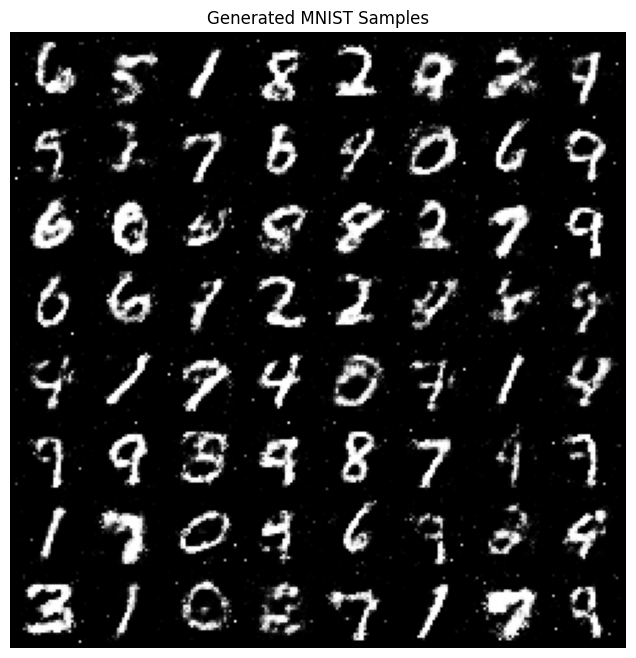

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# -----------------------------
# Configuration
# -----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

latent_dim    = 100
batch_size    = 128
learning_rate = 2e-4
num_epochs    = 20
image_size    = 28 * 28

# -----------------------------
# Dataset & DataLoader
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # scale to [-1,1]
])
train_dataset = datasets.MNIST(
    './data', train=True, download=True, transform=transform
)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True
)

# -----------------------------
# Generator
# -----------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, image_size),
            nn.Tanh()  # output in [-1,1]
        )
    def forward(self, z):
        x = self.net(z)
        return x.view(z.size(0), 1, 28, 28)

# -----------------------------
# Discriminator
# -----------------------------
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, img):
        flat = img.view(img.size(0), -1)
        return self.net(flat)

# Instantiate
gen  = Generator(latent_dim).to(DEVICE)
disc = Discriminator().to(DEVICE)

# -----------------------------
# Loss & Optimizers
# -----------------------------
criterion   = nn.BCELoss()
opt_g = optim.Adam(gen.parameters(),  lr=learning_rate, betas=(0.5, 0.999))
opt_d = optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# -----------------------------
# Training Loop
# -----------------------------
for epoch in range(1, num_epochs+1):
    gen.train()
    disc.train()
    running_d, running_g = 0.0, 0.0

    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(DEVICE)
        bs = real_imgs.size(0)

        # --- Train Discriminator ---
        opt_d.zero_grad()
        # Real
        labels_real = torch.ones(bs,1,device=DEVICE)
        output_real = disc(real_imgs)
        loss_real   = criterion(output_real, labels_real)
        # Fake
        z = torch.randn(bs, latent_dim, device=DEVICE) # [bs, latent_dim]
        fake_imgs = gen(z).detach()
        labels_fake = torch.zeros(bs,1,device=DEVICE)
        output_fake = disc(fake_imgs)
        loss_fake   = criterion(output_fake, labels_fake)
        # Backprop
        loss_d = loss_real + loss_fake
        loss_d.backward()
        opt_d.step()

        # --- Train Generator ---
        opt_g.zero_grad()
        z = torch.randn(bs, latent_dim, device=DEVICE)
        gen_imgs = gen(z)
        labels_gen = torch.ones(bs,1,device=DEVICE)  # fool the discriminator
        output_gen = disc(gen_imgs)
        loss_g     = criterion(output_gen, labels_gen)
        loss_g.backward()
        opt_g.step()

        running_d += loss_d.item() * bs
        running_g += loss_g.item() * bs

    avg_d = running_d / len(train_loader.dataset)
    avg_g = running_g / len(train_loader.dataset)
    print(f"Epoch {epoch}/{num_epochs}  Loss_D: {avg_d:.4f}  Loss_G: {avg_g:.4f}")

# -----------------------------
# Sample & Plot
# -----------------------------
gen.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim, device=DEVICE)
    samples = gen(z).cpu()
    grid = utils.make_grid(samples, nrow=8, normalize=True)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1,2,0), cmap='gray')
    plt.axis('off')
    plt.title("Generated MNIST Samples")
    plt.show()

## 3. Conditional GANs (cGANs)

### 3.1 Motivation
Standard GANs generate data without control. To generate conditioned samples (e.g., digits of a certain class), we extend to **Conditional GANs (cGANs)**.

### 3.2 Formulation

Both $ G $ and $ D $ are conditioned on extra information $ \mathbf{y} $ (e.g., labels):

- Generator:  
  
  $$
  G(\mathbf{z}, \mathbf{y}) \to \hat{\mathbf{x}}
  $$

- Discriminator:  
  
  $$
  D(\mathbf{x}, \mathbf{y}) \to \{0,1\}
  $$

### 3.3 Conditional GAN Objective

$$
\min_{G} \max_{D} \; V(D, G) = \mathbb{E}_{\mathbf{x} \sim p_{\text{data}}(\mathbf{x})} [\log D(\mathbf{x}, \mathbf{y})] + \mathbb{E}_{\mathbf{z} \sim p(\mathbf{z})} [\log (1 - D(G(\mathbf{z}, \mathbf{y}), \mathbf{y}))]
$$

- $ D $ ensures generated samples are not only realistic but also consistent with condition $ \mathbf{y} $.  
- $ G $ learns to generate samples matching both realism and condition.

### 3.4 Training Procedure

1. Sample real pairs $ (\mathbf{x}, \mathbf{y}) \sim p_{\text{data}} $.  
2. Sample noise $ \mathbf{z} \sim p(\mathbf{z}) $ and random labels $ \mathbf{y} $.  
3. Train $ D $ to classify real pairs as real, fake pairs $ (G(\mathbf{z}, \mathbf{y}), \mathbf{y}) $ as fake.  
4. Train $ G $ to generate samples that fool $ D $ under condition $ \mathbf{y} $.  

Using device: cuda
Epoch 1/20  Loss_D: 1.2892  Loss_G: 0.8639
Epoch 2/20  Loss_D: 1.2670  Loss_G: 0.9454
Epoch 3/20  Loss_D: 1.2165  Loss_G: 1.0310
Epoch 4/20  Loss_D: 1.2213  Loss_G: 1.0352
Epoch 5/20  Loss_D: 1.2447  Loss_G: 0.9664
Epoch 6/20  Loss_D: 1.2644  Loss_G: 0.9323
Epoch 7/20  Loss_D: 1.2582  Loss_G: 0.9256
Epoch 8/20  Loss_D: 1.2725  Loss_G: 0.9074
Epoch 9/20  Loss_D: 1.2824  Loss_G: 0.8873
Epoch 10/20  Loss_D: 1.2957  Loss_G: 0.8715
Epoch 11/20  Loss_D: 1.3070  Loss_G: 0.8450
Epoch 12/20  Loss_D: 1.3135  Loss_G: 0.8375
Epoch 13/20  Loss_D: 1.3127  Loss_G: 0.8387
Epoch 14/20  Loss_D: 1.3154  Loss_G: 0.8345
Epoch 15/20  Loss_D: 1.3178  Loss_G: 0.8278
Epoch 16/20  Loss_D: 1.3244  Loss_G: 0.8203
Epoch 17/20  Loss_D: 1.3257  Loss_G: 0.8163
Epoch 18/20  Loss_D: 1.3281  Loss_G: 0.8072
Epoch 19/20  Loss_D: 1.3311  Loss_G: 0.8102
Epoch 20/20  Loss_D: 1.3312  Loss_G: 0.8049


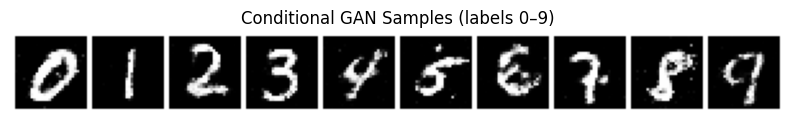

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# -----------------------------
# Configuration
# -----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

latent_dim    = 100
label_dim     = 10
batch_size    = 128
learning_rate = 2e-4
num_epochs    = 20
image_size    = 28 * 28

# -----------------------------
# Data
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # scale to [-1,1]
])
train_ds = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    num_workers=0, pin_memory=True
)

# -----------------------------
# One‐hot helper
# -----------------------------
def one_hot(labels, num_classes):
    return torch.eye(num_classes, device=labels.device)[labels]

# -----------------------------
# Conditional Generator
# -----------------------------
class CGANGenerator(nn.Module):
    def __init__(self, latent_dim, label_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim + label_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, z, labels):
        x = torch.cat([z, labels], dim=1)
        out = self.net(x)
        return out.view(-1, 1, 28, 28)

# -----------------------------
# Conditional Discriminator
# -----------------------------
class CGANDiscriminator(nn.Module):
    def __init__(self, label_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(image_size + label_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        flat = img.view(img.size(0), -1)
        x = torch.cat([flat, labels], dim=1)
        return self.net(x)

# Instantiate models
gen  = CGANGenerator(latent_dim, label_dim).to(DEVICE)
disc = CGANDiscriminator(label_dim).to(DEVICE)

# -----------------------------
# Loss & Optimizers
# -----------------------------
criterion = nn.BCELoss()
opt_g = optim.Adam(gen.parameters(),  lr=learning_rate, betas=(0.5, 0.999))
opt_d = optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# -----------------------------
# Training Loop
# -----------------------------
for epoch in range(1, num_epochs+1):
    gen.train()
    disc.train()
    running_d, running_g = 0.0, 0.0

    for real_imgs, labels in train_loader:
        real_imgs = real_imgs.to(DEVICE)
        labels    = labels.to(DEVICE)
        bs        = real_imgs.size(0)
        onehot    = one_hot(labels, label_dim)

        # Train Discriminator
        opt_d.zero_grad()
        # Real
        real_targets = torch.ones(bs,1,device=DEVICE)
        out_real = disc(real_imgs, onehot)
        loss_real = criterion(out_real, real_targets)
        # Fake
        z = torch.randn(bs, latent_dim, device=DEVICE)
        fake_imgs = gen(z, onehot).detach()
        fake_targets = torch.zeros(bs,1,device=DEVICE)
        out_fake = disc(fake_imgs, onehot)
        loss_fake = criterion(out_fake, fake_targets)
        loss_d = loss_real + loss_fake
        loss_d.backward()
        opt_d.step()

        # Train Generator
        opt_g.zero_grad()
        z = torch.randn(bs, latent_dim, device=DEVICE)
        gen_imgs = gen(z, onehot)
        gen_targets = torch.ones(bs,1,device=DEVICE)
        out_gen = disc(gen_imgs, onehot)
        loss_g = criterion(out_gen, gen_targets)
        loss_g.backward()
        opt_g.step()

        running_d += loss_d.item() * bs
        running_g += loss_g.item() * bs

    avg_d = running_d / len(train_loader.dataset)
    avg_g = running_g / len(train_loader.dataset)
    print(f"Epoch {epoch}/{num_epochs}  Loss_D: {avg_d:.4f}  Loss_G: {avg_g:.4f}")

# -----------------------------
# Inference: sample one per class
# -----------------------------
gen.eval()
with torch.no_grad():
    n_samples = 10
    z = torch.randn(n_samples, latent_dim, device=DEVICE)
    labels = torch.arange(n_samples, device=DEVICE)
    onehot = one_hot(labels, label_dim)
    samples = gen(z, onehot).cpu()
    samples = (samples + 1) / 2  # to [0,1]

    grid = utils.make_grid(samples, nrow=10, normalize=False, pad_value=1)
    plt.figure(figsize=(10,2))
    plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray')
    plt.title("Conditional GAN Samples (labels 0–9)")
    plt.axis('off')
    plt.show()

## 4. Summary

- **CVAEs** extend VAEs to **controlled, conditional generation**.  
- **GANs** learn a generative model via **adversarial training** between Generator and Discriminator.  
- **cGANs** introduce conditioning variables, enabling controlled sample generation with adversarial training.  

These methods combine **representation learning** with **powerful generative modeling**, laying the foundation for modern generative AI.